<a href="https://colab.research.google.com/github/Segrey372017/gb_ML_in_business/blob/main/ssmirnov_ml_business_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, classification_report, log_loss
 

#Домашняя работа к Уроку 5

### Задание 1
<p> Для нашего пайплайна (Case1) поэкспериментировать с разными моделями:
<ul> 
   <li> бустинг </li>
  <li> логистическая регрессия </li>
</ul>
</p>

In [ ]:
#!wget 'https://drive.google.com/uc?export=download&id=1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91' -O hw5_churn_data.csv

In [ ]:
DATA_LINK = 'https://raw.githubusercontent.com/Segrey372017/gb_ML_in_business/310a500f1bcefb375bd42e8c6b0192ae1be15ac5/hw5_churn_data.csv' # датасет загружен на гит

In [ ]:
df = pd.read_csv(DATA_LINK)

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [ ]:
7963/2037

3.9091801669121256

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [ ]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Селектор для выбора категориальных текстовых колонок
    """
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    """
    Кодировщик категориальных признаков в разреженные векторы
    """
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

class MinMaxEncoder(BaseEstimator, TransformerMixin):
    """
    Класс для маштабирования данных в диапазон [-1:1]

    """
    def __init__(self):
        self.MinMax = MinMaxScaler(feature_range = (-1,1))
        return

    def fit(self, X, y = None):
        self.MinMax.fit(X)
        return

    def transform(self, X):
        return self.MinMax.transform(X)


In [ ]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [ ]:
# Отбираем категориальные и количественные признаки в разные списки
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [ ]:
# протестируем пайплайн для количественных признаков
num_transformer = Pipeline([
                            ('selector', NumberSelector(key = 'CreditScore')),
                             ('min_max', MinMaxEncoder())
                             ])

In [ ]:
num_transformer.fit(X_train)

Pipeline(steps=[('selector', NumberSelector(key='CreditScore')),
                ('min_max', MinMaxEncoder())])

In [ ]:
min(num_transformer.transform(X_train))

array([-1.])

In [ ]:
# Теперь нам нужно под каждый признак создать трансформер и объединить их в список.
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('min_max', MinMaxScaler((-1,1))) # что-то не заработало на этабе сборки пайплайна применяю скалер без обертки
            ])
    
    final_transformers.append((cont_col, cont_transformer))

In [ ]:
# Объединим все это в единый пайплайн
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [ ]:
# создадим пайплайны для соответствующих модлей
LR_classifier = Pipeline([('feature_processing', feature_processing),
                         ('classifier', LogisticRegression())]
                         )

LGBM_classifier = Pipeline( [('feature_processing', feature_processing),
                           ('classifier', LGBMClassifier(n_estimators = 100, silent = True, random_state= 12))]

                         )

Обучаем модели

In [ ]:
%%time
LR_classifier.fit(X_train, y_train)

CPU times: user 109 ms, sys: 49.4 ms, total: 158 ms
Wall time: 112 ms


Pipeline(steps=[('feature_processing',
                 Pipeline(steps=[('feats',
                                  FeatureUnion(transformer_list=[('Geography',
                                                                  Pipeline(steps=[('selector',
                                                                                   FeatureSelector(column='Geography')),
                                                                                  ('ohe',
                                                                                   OHEEncoder(key='Geography'))])),
                                                                 ('Gender',
                                                                  Pipeline(steps=[('selector',
                                                                                   FeatureSelector(column='Gender')),
                                                                                  ('ohe',
                                      

In [ ]:
%%time
LGBM_classifier.fit(X_train, y_train)

CPU times: user 405 ms, sys: 11.3 ms, total: 416 ms
Wall time: 254 ms


Pipeline(steps=[('feature_processing',
                 Pipeline(steps=[('feats',
                                  FeatureUnion(transformer_list=[('Geography',
                                                                  Pipeline(steps=[('selector',
                                                                                   FeatureSelector(column='Geography')),
                                                                                  ('ohe',
                                                                                   OHEEncoder(key='Geography'))])),
                                                                 ('Gender',
                                                                  Pipeline(steps=[('selector',
                                                                                   FeatureSelector(column='Gender')),
                                                                                  ('ohe',
                                      

In [ ]:
y_LR_preds = LR_classifier.predict_proba(X_test)[:, 1]
y_LR_preds[:10]

array([0.22887941, 0.33469817, 0.15375075, 0.12523701, 0.15563266,
       0.64044916, 0.06257609, 0.07861492, 0.36485072, 0.7646624 ])

In [ ]:
y_LGBM_preds = LGBM_classifier.predict_proba(X_test)[:, 1]
y_LGBM_preds[:10]

array([0.34307948, 0.25243662, 0.1441027 , 0.04057859, 0.03532505,
       0.92669428, 0.07014209, 0.06560687, 0.10517906, 0.71983354])

### Задание 2
<p> Отобрать лучшую модель по метрикам (какая по вашему мнению здесь наиболее подходящая ML-метрика)</p>

In [ ]:
# функция для получени метрик модели и подбора наилучшего порога
def get_treshold(y_test, y_score, b = 1):
    """
    Функция для подбора оптимального порога вероятности.
    Максимизирует F-score
    """

    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    auc = roc_auc_score(y_test, y_score)
    # логарифм потерь
    llos = log_loss(y_test, y_score)
    # отдадим в виде словаря порог вероятности и метрики
    return {'BestTreshold': thresholds[ix], 'Precision': precision[ix], 'Recall': recall[ix], 'ROC_AUC': auc, 'F-Score':fscore[ix],'log-loss': llos}

In [ ]:
LR_result = get_treshold(y_test, y_LR_preds)

In [ ]:
LGBM_result = get_treshold(y_test, y_LGBM_preds)

In [ ]:
res_tab = pd.DataFrame(data = [LR_result, LGBM_result], index = ['Logistic_Reg', 'LGBM_Classifier'])
res_tab.sort_values(by = 'F-Score', ascending = False)

,BestTreshold,Precision,Recall,ROC_AUC,F-Score,log-loss
LGBM_Classifier,0.344127,0.623400,0.669941,0.874785,0.645833,0.325192
Logistic_Reg,0.287666,0.461905,0.571709,0.771902,0.510975,0.426828


<p> Наиболее подходящей метрикой, как и в большинстве случаев является F-score как агрегированный показатель точности и полноты классификации. При высоких значениях ROC_AUC она позволяет трезво взглянуть на то что эффективность обоих моделей недалеко ушла от простого 50/50. </p>
<p> Ожидаемо модель бустинга показала лучший результат</p>

### Задание 3
<p> Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2:<br>
a. 1 доллар на удержание <br>
b. 2 доллара - с каждого правильно классифицированного (True Positive)<br>
 </p>

In [ ]:
# Функциюя для отрисовки матрицы соответсвия
def show_matrix(y_true, y_pred, classes, title):
    """
    Отрисовка матрицы соответсвия средствами seaborn

    """
    plt.title(title)
    cnf = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cnf, cmap = 'Blues', annot = True, fmt = ".1f", linecolor= 'black',
                linewidths= 1, xticklabels= classes, yticklabels= classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    
    plt.figure(figsize = (8,8))
    plt.show()

    return

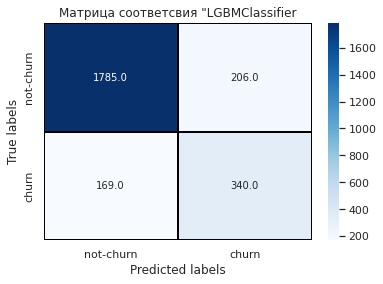

<Figure size 576x576 with 0 Axes>

In [ ]:
show_matrix(y_test, y_LGBM_preds > res_tab.BestTreshold.loc['LGBM_Classifier'],
            classes = ['not-churn', 'churn'],
            title = 'Mатрица соответсвия "LGBMClassifier')

In [ ]:
# функция для подсчета финансового результата
def fin_results(y_true, y_pred, hold_cost = 1, user_income = 2):
    cnf = confusion_matrix(y_true, y_pred)

    TN = cnf[0][0]
    FP = cnf[0][1]
    FN = cnf[1][0]
    TP = cnf[1][1]
    
    income = TP * user_income
    retain_sum = (TP + FN) * hold_cost

    return {'prof' :income - retain_sum, 'income':income, 'retain_sum': retain_sum, 'TN': TN, 'FP':FP, 'FN': FN, 'TP':TP}

In [ ]:
f_results = fin_results(y_test, y_LGBM_preds > res_tab.BestTreshold.loc['LGBM_Classifier'])


In [ ]:
f_results

{'FN': 169,
 'FP': 206,
 'TN': 1785,
 'TP': 340,
 'income': 680,
 'prof': 171,
 'retain_sum': 509}

In [ ]:
print('Ожидаемая прибыль от применения модели (долл.): ', f_results['prof'] )
print(f'Общие затраты на удержание клиентов  (долл.): ', f_results['retain_sum'] )
print(f'Рентабельность мероприятия по удержанию клиентов с помощью ML  (долл.): ', f_results['prof'] / f_results['retain_sum']*100 )

Ожидаемая прибыль от применения модели (долл.):  171
Общие затраты на удержание клиентов  (долл.):  509
Рентабельность мероприятия по удержанию клиентов с помощью ML  (долл.):  33.59528487229863


В принципе применение даже довольно упрощенной модели дает вполне привлекательную операционную рентабельность.

### Задание 4
Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [ ]:
# задаем сетку параметров
cv_params = {'classifier__n_estimators' : [50, 100, 120, 150, 200], # количество решающих деревьев
             'classifier__class_weight' : [None, {0:4, 1:1}],
             'classifier__reg_lambda' : [0.0, 0.1, 0.2, 0.6]}

In [ ]:
%%time
grid = GridSearchCV(LGBM_classifier,
                    param_grid=cv_params,
                    cv=5,
                    refit=False)

search = grid.fit(X_train, y_train)


CPU times: user 1min 42s, sys: 2.53 s, total: 1min 45s
Wall time: 59.1 s


In [ ]:
search.best_params_

{'classifier__class_weight': None,
 'classifier__n_estimators': 50,
 'classifier__reg_lambda': 0.2}

Оптимальные параметры: {'classifier__class_weight': None,
 'classifier__n_estimators': 50,
 'classifier__reg_lambda': 0.2}

In [ ]:
# выполним обучение модели и предсказание с оптимальными параметрами
LGBM_classifier2 = Pipeline( [('feature_processing', feature_processing),
                           ('classifier', LGBMClassifier(n_estimators = 50, silent = True, class_weight = None, reg_lambda = 0.2,
                                                         random_state= 12))]

                         )

In [ ]:
LGBM_classifier2.fit(X_train, y_train)

Pipeline(steps=[('feature_processing',
                 Pipeline(steps=[('feats',
                                  FeatureUnion(transformer_list=[('Geography',
                                                                  Pipeline(steps=[('selector',
                                                                                   FeatureSelector(column='Geography')),
                                                                                  ('ohe',
                                                                                   OHEEncoder(key='Geography'))])),
                                                                 ('Gender',
                                                                  Pipeline(steps=[('selector',
                                                                                   FeatureSelector(column='Gender')),
                                                                                  ('ohe',
                                      

In [ ]:
y_LGBM2_preds = LGBM_classifier2.predict_proba(X_test)[:, 1]

In [ ]:
LGBM2_result = get_treshold(y_test, y_LGBM2_preds)


In [ ]:
res_tab = pd.DataFrame(data = [LR_result, LGBM_result, LGBM2_result], index = ['Logistic_Reg', 'LGBM_Classifier','LGBM_Classifier2'])
res_tab.sort_values(by = 'F-Score', ascending = False)

,BestTreshold,Precision,Recall,ROC_AUC,F-Score,log-loss
LGBM_Classifier2,0.357344,0.647860,0.654224,0.876500,0.651026,0.324924
LGBM_Classifier,0.344127,0.623400,0.669941,0.874785,0.645833,0.325192
Logistic_Reg,0.287666,0.461905,0.571709,0.771902,0.510975,0.426828


Модель с подгонкой параметров оказалась немного 1-2% более эффективной. Проверим как это скажется на финансовых результатах

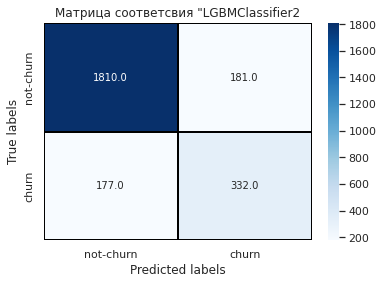

<Figure size 576x576 with 0 Axes>

In [ ]:
show_matrix(y_test, y_LGBM2_preds > res_tab.BestTreshold.loc['LGBM_Classifier2'],
            classes = ['not-churn', 'churn'],
            title = 'Mатрица соответсвия "LGBMClassifier2')

### Задание 5
<p>Еще раз провести оценку экономической эффективности </p>

Точность модели по-видимому увеличилась за счет повышения точности распознавания лояльных клиентов (non-churn)

In [ ]:
# оценим финансовый результат
f_results = fin_results(y_test, y_LGBM2_preds > res_tab.BestTreshold.loc['LGBM_Classifier2'])

In [ ]:
print('Ожидаемая прибыль от применения модели (долл.): ', f_results['prof'] )
print(f'Общие затраты на удержание клиентов  (долл.): ', f_results['retain_sum'] )
print(f'Рентабельность мероприятия по удержанию клиентов с помощью ML  (долл.): ', f_results['prof'] / f_results['retain_sum']*100 )

Ожидаемая прибыль от применения модели (долл.):  155
Общие затраты на удержание клиентов  (долл.):  509
Рентабельность мероприятия по удержанию клиентов с помощью ML  (долл.):  30.451866404715126


К сожалению, экономические расчеты показали, что предудущая модель оказалась эффективнее с точки зрения бизнеса.